In [46]:
# Специализированные библиотеки для токсикологической классификации CC50
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve,
                             matthews_corrcoef, cohen_kappa_score)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, f1_score, precision_score,
                             recall_score, confusion_matrix, roc_curve)
import warnings
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score

warnings.filterwarnings('ignore')

# Визуальные настройки для токсикологического анализа
plt.style.use('seaborn-v0_8-bright')
sns.set_palette("Set1")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
target = 'CC50, mM'

In [47]:
df = pd.read_parquet("data/processed_data_full.parquet")

In [48]:
df["CC50_gt_median"] = (df[target] > df[target].median()).astype(int)
df

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI,CC50_gt_median
0,-1.763647,1.227715,0.858123,-0.755891,1.073323,0.258081,-1.556297,1.522921,-2.064995,-0.581532,...,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,6.239374,175.482382,28.125000,0
1,-2.108224,2.095440,0.951585,-0.544168,1.254983,0.289724,-1.759553,1.260180,-2.212699,-0.571135,...,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,0.771831,5.402819,7.000000,0
2,-2.514136,2.150839,0.957552,-1.490120,1.014426,0.745889,-1.118121,1.099403,-2.397328,-0.545366,...,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,223.808778,161.142320,0.720000,0
3,-1.762654,1.247702,0.860276,-0.941357,0.988562,0.368166,-1.556297,1.522921,-2.156673,-0.581603,...,-0.032191,-0.032191,-0.238522,-0.27518,3.075405,-0.085436,1.705624,107.855654,63.235294,0
4,-1.746485,0.536885,0.783714,-0.701088,0.563542,0.902106,-1.367945,2.002451,-2.242239,-0.580930,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,107.131532,139.270991,1.300000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,0.621634,-0.779389,0.307862,-0.918328,1.566453,0.492661,0.628761,-0.790557,-0.036530,-0.461498,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.000104,34.999650,1.129017,0
962,0.834722,-0.884119,0.165598,-0.980878,1.201620,1.050498,0.704502,-0.776102,-0.233468,-0.461496,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.999934,33.999415,1.062484,0
963,0.943127,-0.906571,0.196551,-1.377478,0.997433,1.522336,0.707042,-0.775993,0.065049,0.598260,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,30.999883,33.999458,1.096761,0
964,0.893994,-0.196583,-0.286468,-0.923926,0.761096,1.340989,0.586631,-0.792770,-1.593940,-0.464683,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.998959,32.999644,1.031272,0


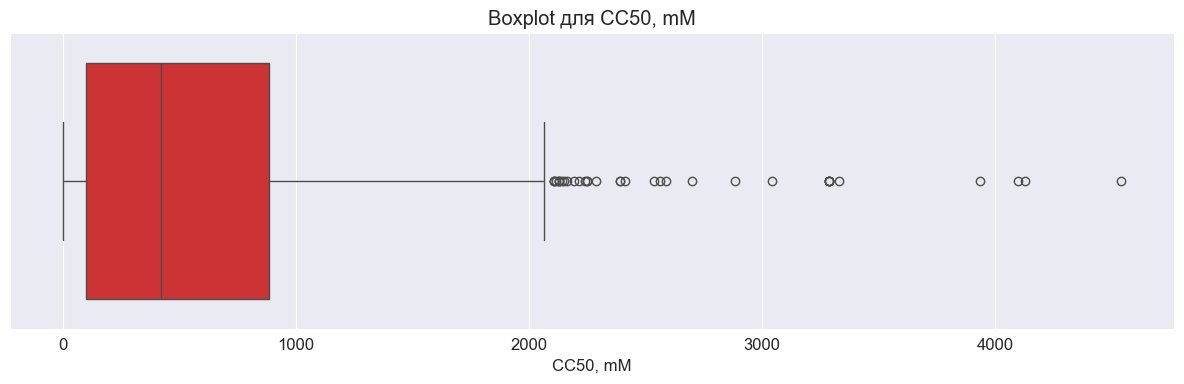

In [49]:
plt.figure(figsize=(12, 4))

sns.boxplot(x=df[target])

plt.title(f'Boxplot для {target}')
plt.tight_layout()
plt.show()

In [50]:
mean = df[target].mean()
std = df[target].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

outliers = df[(df[target] < lower_bound) | (df[target] > upper_bound)]

print("Выбросы:")
outliers

Выбросы:


,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI,CC50_gt_median
29,0.167835,-0.492682,-0.336254,-0.374021,-1.320181,-0.844268,1.703838,0.676161,1.738376,0.600354,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,4095.188563,4095.188563,1.000000,1
30,0.189542,-0.534596,0.041379,-0.600427,-1.479133,-0.859744,1.703837,0.676161,1.996858,0.598273,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,4128.529377,4128.529377,1.000000,1
49,-0.635122,0.032249,0.729359,0.664412,1.022232,-1.227931,-1.369949,0.189156,1.184487,-0.484354,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,13.824389,2560.072092,185.185185,1
80,-0.621559,0.484260,0.778045,0.676892,1.203891,-1.212109,-1.425447,0.181197,0.889080,-0.484343,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,83.619244,2533.916472,30.303030,1
82,0.279511,-1.022494,0.606901,-0.271209,1.382454,-1.565942,-0.732016,1.457456,0.915935,-0.491791,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,32.843311,3284.331113,100.000000,1
83,0.279511,-1.022494,0.606901,-0.271209,1.382454,-1.565942,-0.732016,1.457456,0.915935,-0.491791,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,2200.501846,3284.331113,1.492537,1
84,0.207366,-0.912915,0.627556,-0.271209,1.382454,-1.565942,-0.771254,1.449725,0.915935,-0.491883,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,679.856540,3284.331113,4.830918,1
94,0.207366,-0.912915,0.627556,-0.271209,1.382454,-1.565942,-0.771254,1.449725,0.915935,-0.491883,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,1646.106754,3284.331113,1.995211,1
95,0.279511,-1.022494,0.606901,-0.271209,1.382454,-1.565942,-0.732016,1.457456,0.915935,-0.491791,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,3284.331113,3284.331113,1.000000,1
110,-1.850559,1.442062,0.881210,0.261183,1.022232,-1.243408,-1.558355,1.522779,0.889080,-0.582397,...,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,19.655003,2586.184602,131.578947,1


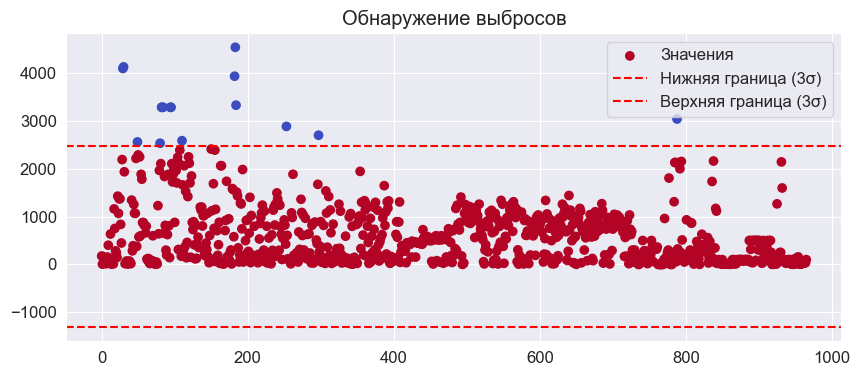

In [51]:
df['is_outlier_3σ'] = (df[target] < lower_bound) | (df[target] > upper_bound)

plt.figure(figsize=(10, 4))
plt.scatter(df.index, df[target], c=~df['is_outlier_3σ'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (3σ)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (3σ)')
plt.legend()
plt.title('Обнаружение выбросов')
plt.show()

In [52]:
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df["is_outlier_IQR"] = (df[target] < lower_bound) | (df[target] > upper_bound)
df[(df[target] < lower_bound) | (df[target] > upper_bound)]

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM","CC50, mM",SI,CC50_gt_median,is_outlier_3σ,is_outlier_IQR
28,0.162671,-0.598151,0.036863,-0.765315,-1.485425,-0.969830,1.703837,0.676161,1.893465,0.598264,...,-0.238522,-0.27518,-0.169643,-0.085436,1472.457163,2191.156492,1.488095,1,False,True
29,0.167835,-0.492682,-0.336254,-0.374021,-1.320181,-0.844268,1.703838,0.676161,1.738376,0.600354,...,-0.238522,-0.27518,-0.169643,-0.085436,4095.188563,4095.188563,1.000000,1,True,True
30,0.189542,-0.534596,0.041379,-0.600427,-1.479133,-0.859744,1.703837,0.676161,1.996858,0.598273,...,-0.238522,-0.27518,-0.169643,-0.085436,4128.529377,4128.529377,1.000000,1,True,True
47,-1.758664,1.295320,0.865404,-1.586508,0.639545,0.918595,-1.556297,1.522921,-2.534171,-0.581647,...,-0.238522,-0.27518,7.131714,-0.085436,45.006900,2216.216562,49.241706,1,False,True
49,-0.635122,0.032249,0.729359,0.664412,1.022232,-1.227931,-1.369949,0.189156,1.184487,-0.484354,...,-0.238522,-0.27518,-0.169643,-0.085436,13.824389,2560.072092,185.185185,1,True,True
50,-0.635122,0.032249,0.729359,0.664412,1.022232,-1.227931,-1.369949,0.189156,1.184487,-0.484354,...,-0.238522,-0.27518,-0.169643,-0.085436,3.584101,2288.704450,638.571429,1,False,True
52,-1.826221,1.260922,0.861699,0.649104,0.751162,-1.015482,-1.456664,1.337425,0.704450,-0.564981,...,-0.238522,-0.27518,-0.169643,-0.085436,37.324004,2248.433966,60.240964,1,False,True
80,-0.621559,0.484260,0.778045,0.676892,1.203891,-1.212109,-1.425447,0.181197,0.889080,-0.484343,...,-0.238522,-0.27518,-0.169643,-0.085436,83.619244,2533.916472,30.303030,1,True,True
81,-1.804546,1.252536,0.860796,0.426238,0.681620,-0.897486,-1.094176,1.049085,0.385150,-0.550391,...,-0.238522,-0.27518,-0.169643,-0.085436,4.212087,2106.043502,500.000000,1,False,True
82,0.279511,-1.022494,0.606901,-0.271209,1.382454,-1.565942,-0.732016,1.457456,0.915935,-0.491791,...,-0.238522,-0.27518,-0.169643,-0.085436,32.843311,3284.331113,100.000000,1,True,True


In [53]:
target_old = target
target = "CC50_gt_median"

In [54]:
# data_cleaned_IQR = df[~df['is_outlier_IQR']].drop(columns=['is_outlier_IQR', 'is_outlier_3σ'])
data_cleaned_IQR = df[~df['is_outlier_3σ']].drop(columns=['is_outlier_IQR', 'is_outlier_3σ', target_old])

data_cleaned_IQR

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"IC50, mM",SI,CC50_gt_median
0,-1.763647,1.227715,0.858123,-0.755891,1.073323,0.258081,-1.556297,1.522921,-2.064995,-0.581532,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,6.239374,28.125000,0
1,-2.108224,2.095440,0.951585,-0.544168,1.254983,0.289724,-1.759553,1.260180,-2.212699,-0.571135,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,0.771831,7.000000,0
2,-2.514136,2.150839,0.957552,-1.490120,1.014426,0.745889,-1.118121,1.099403,-2.397328,-0.545366,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436,223.808778,0.720000,0
3,-1.762654,1.247702,0.860276,-0.941357,0.988562,0.368166,-1.556297,1.522921,-2.156673,-0.581603,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,3.075405,-0.085436,1.705624,63.235294,0
4,-1.746485,0.536885,0.783714,-0.701088,0.563542,0.902106,-1.367945,2.002451,-2.242239,-0.580930,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,107.131532,1.300000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,0.621634,-0.779389,0.307862,-0.918328,1.566453,0.492661,0.628761,-0.790557,-0.036530,-0.461498,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.000104,1.129017,0
962,0.834722,-0.884119,0.165598,-0.980878,1.201620,1.050498,0.704502,-0.776102,-0.233468,-0.461496,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.999934,1.062484,0
963,0.943127,-0.906571,0.196551,-1.377478,0.997433,1.522336,0.707042,-0.775993,0.065049,0.598260,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,30.999883,1.096761,0
964,0.893994,-0.196583,-0.286468,-0.923926,0.761096,1.340989,0.586631,-0.792770,-1.593940,-0.464683,...,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436,31.998959,1.031272,0


In [55]:
X = data_cleaned_IQR[data_cleaned_IQR.columns[:-3]]
y_ic50 = data_cleaned_IQR[target]

In [56]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-1.763647,1.227715,0.858123,-0.755891,1.073323,0.258081,-1.556297,1.522921,-2.064995,-0.581532,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436
1,-2.108224,2.095440,0.951585,-0.544168,1.254983,0.289724,-1.759553,1.260180,-2.212699,-0.571135,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436
2,-2.514136,2.150839,0.957552,-1.490120,1.014426,0.745889,-1.118121,1.099403,-2.397328,-0.545366,...,6.369345,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,2.264143,-0.085436
3,-1.762654,1.247702,0.860276,-0.941357,0.988562,0.368166,-1.556297,1.522921,-2.156673,-0.581603,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,3.075405,-0.085436
4,-1.746485,0.536885,0.783714,-0.701088,0.563542,0.902106,-1.367945,2.002451,-2.242239,-0.580930,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,0.621634,-0.779389,0.307862,-0.918328,1.566453,0.492661,0.628761,-0.790557,-0.036530,-0.461498,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436
962,0.834722,-0.884119,0.165598,-0.980878,1.201620,1.050498,0.704502,-0.776102,-0.233468,-0.461496,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436
963,0.943127,-0.906571,0.196551,-1.377478,0.997433,1.522336,0.707042,-0.775993,0.065049,0.598260,...,-0.179657,3.613328,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436
964,0.893994,-0.196583,-0.286468,-0.923926,0.761096,1.340989,0.586631,-0.792770,-1.593940,-0.464683,...,-0.179657,-0.209755,-0.112154,-0.096976,-0.032191,-0.032191,-0.238522,-0.27518,-0.169643,-0.085436


In [57]:
y_ic50

0      0
1      0
2      0
3      0
4      0
      ..
961    0
962    0
963    0
964    0
965    0
Name: CC50_gt_median, Length: 950, dtype: int64

In [58]:
X_train, X_test, y_train_ic50, y_test_ic50 = train_test_split(
    X, y_ic50, test_size=0.2, random_state=121
)

In [59]:
MODELS = {
    'logreg': LogisticRegression(random_state=112),
    'rf': RandomForestClassifier(random_state=121),
    'xgb': XGBClassifier(random_state=111),
}

metrics = {
    'ROC-AUC': roc_auc_score,
    'F1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    'PRECISION': lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'),
    'RECALL': lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary')
}

In [61]:
# Метрики
metrics = {
    'ROC-AUC': roc_auc_score,
    'F1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    'PRECISION': lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'),
    'RECALL': lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary')
}

# Модели и их гиперпараметры
MODELS = {
    'logreg': {
        'model': LogisticRegression(solver='liblinear', random_state=112),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    },
    'rf': {
        'model': RandomForestClassifier(random_state=121),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'xgb': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    }
}

results = []

# Сразу ищем лучшую модель и лучшие результаты с подбором гипперпараметров
for name, config in MODELS.items():
    print(f"\nGridSearchCV для модели: {name}")

    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train_ic50)

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Метрики
    model_metrics = {}
    for metric_name, metric_func in metrics.items():
        if metric_name == 'ROC-AUC':
            model_metrics[metric_name] = metric_func(y_test_ic50, y_proba)
        else:
            model_metrics[metric_name] = metric_func(y_test_ic50, y_pred)

    results.append({
        'model': name,
        'best_params': grid.best_params_,
        'cv_mean_roc_auc': grid.best_score_,
        **model_metrics
    })

# Вывод результатов
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ROC-AUC', ascending=False)
results_df


GridSearchCV для модели: logreg
Fitting 5 folds for each of 8 candidates, totalling 40 fits

GridSearchCV для модели: rf
Fitting 5 folds for each of 12 candidates, totalling 60 fits

GridSearchCV для модели: xgb
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,model,best_params,cv_mean_roc_auc,ROC-AUC,F1,PRECISION,RECALL
1,rf,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.819616,0.824911,0.752577,0.730000,0.776596
2,xgb,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.812550,0.815270,0.750000,0.734694,0.765957
0,logreg,"{'C': 0.1, 'penalty': 'l2'}",0.797667,0.810395,0.750000,0.707547,0.797872


Как видим, лучшая модель - Random Forest